# Linear Bidding Strategy

In [1]:
from sklearn.linear_model import LogisticRegression
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import skew

import seaborn as sns
%matplotlib inline

# converts labels into integers, and vice versa, needed by scikit-learn.
label_encoder = LabelEncoder()

# encodes feature dictionaries as numpy vectors, needed by scikit-learn.
vectorizer = DictVectorizer()

In [2]:
train= pd.read_csv("/Users/kamakshibansal/UCL/WebEconomics/Mini_Project/Dataset/train.csv")
test= pd.read_csv("/Users/kamakshibansal/UCL/WebEconomics/Mini_Project/Dataset/test.csv")
validation= pd.read_csv("/Users/kamakshibansal/UCL/WebEconomics/Mini_Project/Dataset/validation.csv")
train.head(10)

,click,weekday,hour,bidid,logtype,userid,useragent,IP,region,city,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,1,14,fdfae6789b787899f1b875de3ab8b21a,1,u_Vh1OPkFv3q5CFdR,windows_ie,180.107.112.*,80,85,...,60,1,0,5,612599432d200b093719dd1f372f7a30,300,54,bebefa5efe83beee17a3d245e7c5085b,1458,"13866,10063"
1,0,2,20,372883147cdefbc495fb5082f79dde9b,1,u_VhkRL6dCOTLsq-c,windows_chrome,125.120.199.*,94,95,...,250,1,0,5,8dff45ed862a740986dbe688aafee7e5,249,42,15b749127478946f161a54dc0dad27c8,3476,"10063,10111"
2,0,5,9,2912cb5947e1fad450e2473c2f61ef75,1,u_VhkyORMrD8TP3GL,windows_ie,120.196.64.*,216,217,...,280,0,1,0,77819d3e0b3467fe5c7b16d68ad923a1,300,76,bebefa5efe83beee17a3d245e7c5085b,1458,10063
3,0,2,20,d7b7d61d1e50e1d27d210928d28a9b61,1,u_VhkyLRqVL2a4eWL,windows_ie,219.131.122.*,216,221,...,90,0,0,162,7184c9560e68e977187e67e45a4f3198,238,182,0f951a030abdaedd733ee8d114ce2944,3427,"10077,10111"
4,0,6,9,657d317dc4045bb79c2652abbea07530,1,u_Vh1zOJuQOtTCBgL,windows_chrome,123.190.78.*,40,48,...,90,0,1,0,c938195f9e404b4f38c7e71bf50263e5,238,34,a3becb967c015e9acb5e72f22b100ef8,3476,"10031,13042,10006,10057,13866,10063,14273,1005..."
5,0,3,22,97948108bc353d0f3ef1e0142afb0343,1,u_Vh5h1p2SDvFsGMa,windows_ie,111.227.172.*,3,6,...,250,1,1,0,911b2d84826786018761e8c0b0a3a60c,227,99,d29e59bf0f7f8243858b8183f14d4412,3358,10063
6,0,5,16,26739c29a9294f157930f3f5bb7f5dc9,1,u_D89EGm6FGGV,windows_chrome,27.46.201.*,216,217,...,90,OtherView,Na,5,7330,277,61,null,2259,"13866,10006,10111,10063"
7,0,0,21,404f5a6f3a1dde4ae1811646c065df3c,1,u_D9MLsHCazAr,windows_chrome,112.92.88.*,216,220,...,90,FirstView,Na,0,10717,294,39,null,2821,"13042,10024,10006,10110,10031,10063"
8,0,4,17,39095668ca6fd532b7c6d3dfad538997,1,u_Vh5_LAT0322yFOl,windows_ie,218.77.12.*,201,213,...,280,2,0,5,ff5123fb9333ca095034c62fdaaf51aa,300,111,361e128affece850342293213691a043,3386,null
9,0,0,17,dd3e2fd0370f672e6cbc5597673f72e1,1,u_VhTnL7d7PtB8XWC,windows_ie,122.137.146.*,55,57,...,90,0,0,31,832b91d59d0cb5731431653204a76c0e,300,30,bebefa5efe83beee17a3d245e7c5085b,1458,"13403,10057,10063,10083,10006,10110"


In [81]:
train.shape

(2697738, 26)

In [3]:
df_train = pd.DataFrame(train.useragent.str.split('_',1).tolist(),
                                   columns = ['OS','browser'])
df_val = pd.DataFrame(validation.useragent.str.split('_',1).tolist(),
                                   columns = ['OS','browser'])

In [66]:
#td = train.T.to_dict(orient='dict')

In [ ]:
# V = DictVectorizer(sparse=False)
# vectorised = V.fit_transform(td[0])

In [4]:
X_train = train.drop(['usertag','click', 'useragent'], axis=1)
y_train = train.click

X_val = validation.drop(['usertag','click','useragent'], axis=1)
y_val = validation.click


from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [7]:
X_train.shape

(2697738, 23)

In [5]:
# df_train = pd.DataFrame(X_train.useragent.str.split('_',1).tolist(),
#                                    columns = ['OS','browser'])
X_val= pd.concat([X_val,df_val],axis=1)
X_train= pd.concat([X_train,df_train],axis=1)
pd.options.display.max_columns = 999
X_train

,weekday,hour,bidid,logtype,userid,IP,region,city,adexchange,domain,url,urlid,slotid,slotwidth,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,OS,browser
0,1,14,fdfae6789b787899f1b875de3ab8b21a,1,u_Vh1OPkFv3q5CFdR,180.107.112.*,80,85,2,trqRTuToMTNUjM9r5rMi,d48a96ab59d7ad741a48e781de44efeb,null,433287550,468,60,1,0,5,612599432d200b093719dd1f372f7a30,300,54,bebefa5efe83beee17a3d245e7c5085b,1458,windows,ie
1,2,20,372883147cdefbc495fb5082f79dde9b,1,u_VhkRL6dCOTLsq-c,125.120.199.*,94,95,2,trqRTv14MqTR1m58uG,313e110c149d24b3236165d30879c595,null,2264242698,250,250,1,0,5,8dff45ed862a740986dbe688aafee7e5,249,42,15b749127478946f161a54dc0dad27c8,3476,windows,chrome
2,5,9,2912cb5947e1fad450e2473c2f61ef75,1,u_VhkyORMrD8TP3GL,120.196.64.*,216,217,1,trqRTJTxX5scg4,845b72208c27b993daa11c8104449e22,null,mm_40135906_3486753_11388735,336,280,0,1,0,77819d3e0b3467fe5c7b16d68ad923a1,300,76,bebefa5efe83beee17a3d245e7c5085b,1458,windows,ie
3,2,20,d7b7d61d1e50e1d27d210928d28a9b61,1,u_VhkyLRqVL2a4eWL,219.131.122.*,216,221,2,trqRTuMvjTN7X9KbuKz,ea6709db2703ae8698755629f1f9df32,null,2536830969,728,90,0,0,162,7184c9560e68e977187e67e45a4f3198,238,182,0f951a030abdaedd733ee8d114ce2944,3427,windows,ie
4,6,9,657d317dc4045bb79c2652abbea07530,1,u_Vh1zOJuQOtTCBgL,123.190.78.*,40,48,1,trqRTu1YP5scFsf,b7b8e74eefbdd5cc1a9f0acb2e5c0d6c,null,mm_10075660_3500949_11453278,950,90,0,1,0,c938195f9e404b4f38c7e71bf50263e5,238,34,a3becb967c015e9acb5e72f22b100ef8,3476,windows,chrome
5,3,22,97948108bc353d0f3ef1e0142afb0343,1,u_Vh5h1p2SDvFsGMa,111.227.172.*,3,6,1,trqRTJubX5scFsf,37bdc8299d3b42e6f04ccf4fca64bacc,null,mm_14539978_2071324_8355258,300,250,1,1,0,911b2d84826786018761e8c0b0a3a60c,227,99,d29e59bf0f7f8243858b8183f14d4412,3358,windows,ie
6,5,16,26739c29a9294f157930f3f5bb7f5dc9,1,u_D89EGm6FGGV,27.46.201.*,216,217,2,333a4ab5e4ae8e17d7ca86237721ba7a,4bf89e8bc0f9e55e8305087441b5276c,null,2932492844,728,90,OtherView,Na,5,7330,277,61,null,2259,windows,chrome
7,0,21,404f5a6f3a1dde4ae1811646c065df3c,1,u_D9MLsHCazAr,112.92.88.*,216,220,4,1164f4caea2d39bc9dcc8dd22bb0e5c8,37a58da844768798ec368daff8a5e94b,null,9223372032560960619,960,90,FirstView,Na,0,10717,294,39,null,2821,windows,chrome
8,4,17,39095668ca6fd532b7c6d3dfad538997,1,u_Vh5_LAT0322yFOl,218.77.12.*,201,213,2,trqRTv1EXQuYgMKE5SqW,da7852090bb61af96fbcd29898929149,null,3151450371,336,280,2,0,5,ff5123fb9333ca095034c62fdaaf51aa,300,111,361e128affece850342293213691a043,3386,windows,ie
9,0,17,dd3e2fd0370f672e6cbc5597673f72e1,1,u_VhTnL7d7PtB8XWC,122.137.146.*,55,57,3,5F1RQS9rg5scFsf,19422c57c90579925952ed859eaf3f4d,null,News_F_bottom_Width,1000,90,0,0,31,832b91d59d0cb5731431653204a76c0e,300,30,bebefa5efe83beee17a3d245e7c5085b,1458,windows,ie


In [6]:
X_train.select_dtypes(include=['object']).columns

Index(['bidid', 'userid', 'IP', 'adexchange', 'domain', 'url', 'urlid',
       'slotid', 'slotvisibility', 'slotformat', 'creative', 'keypage', 'OS',
       'browser'],
      dtype='object')

In [8]:
nonnumeric_columns = ['bidid', 'userid', 'IP', 'adexchange', 'domain',
       'url', 'urlid', 'slotid', 'slotvisibility', 'slotformat','creative', 'keypage', 'OS', 'browser']

In [9]:
big_X = X_train.append(X_val)

In [15]:
big_X_imputed = DataFrameImputer().fit_transform(big_X)
big_X_imputed.head(10)

,weekday,hour,bidid,logtype,userid,IP,region,city,adexchange,domain,url,urlid,slotid,slotwidth,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,OS,browser
0,1,14,fdfae6789b787899f1b875de3ab8b21a,1,u_Vh1OPkFv3q5CFdR,180.107.112.*,80,85,2,trqRTuToMTNUjM9r5rMi,d48a96ab59d7ad741a48e781de44efeb,null,433287550,468,60,1,0,5,612599432d200b093719dd1f372f7a30,300,54,bebefa5efe83beee17a3d245e7c5085b,1458,windows,ie
1,2,20,372883147cdefbc495fb5082f79dde9b,1,u_VhkRL6dCOTLsq-c,125.120.199.*,94,95,2,trqRTv14MqTR1m58uG,313e110c149d24b3236165d30879c595,null,2264242698,250,250,1,0,5,8dff45ed862a740986dbe688aafee7e5,249,42,15b749127478946f161a54dc0dad27c8,3476,windows,chrome
2,5,9,2912cb5947e1fad450e2473c2f61ef75,1,u_VhkyORMrD8TP3GL,120.196.64.*,216,217,1,trqRTJTxX5scg4,845b72208c27b993daa11c8104449e22,null,mm_40135906_3486753_11388735,336,280,0,1,0,77819d3e0b3467fe5c7b16d68ad923a1,300,76,bebefa5efe83beee17a3d245e7c5085b,1458,windows,ie
3,2,20,d7b7d61d1e50e1d27d210928d28a9b61,1,u_VhkyLRqVL2a4eWL,219.131.122.*,216,221,2,trqRTuMvjTN7X9KbuKz,ea6709db2703ae8698755629f1f9df32,null,2536830969,728,90,0,0,162,7184c9560e68e977187e67e45a4f3198,238,182,0f951a030abdaedd733ee8d114ce2944,3427,windows,ie
4,6,9,657d317dc4045bb79c2652abbea07530,1,u_Vh1zOJuQOtTCBgL,123.190.78.*,40,48,1,trqRTu1YP5scFsf,b7b8e74eefbdd5cc1a9f0acb2e5c0d6c,null,mm_10075660_3500949_11453278,950,90,0,1,0,c938195f9e404b4f38c7e71bf50263e5,238,34,a3becb967c015e9acb5e72f22b100ef8,3476,windows,chrome
5,3,22,97948108bc353d0f3ef1e0142afb0343,1,u_Vh5h1p2SDvFsGMa,111.227.172.*,3,6,1,trqRTJubX5scFsf,37bdc8299d3b42e6f04ccf4fca64bacc,null,mm_14539978_2071324_8355258,300,250,1,1,0,911b2d84826786018761e8c0b0a3a60c,227,99,d29e59bf0f7f8243858b8183f14d4412,3358,windows,ie
6,5,16,26739c29a9294f157930f3f5bb7f5dc9,1,u_D89EGm6FGGV,27.46.201.*,216,217,2,333a4ab5e4ae8e17d7ca86237721ba7a,4bf89e8bc0f9e55e8305087441b5276c,null,2932492844,728,90,OtherView,Na,5,7330,277,61,null,2259,windows,chrome
7,0,21,404f5a6f3a1dde4ae1811646c065df3c,1,u_D9MLsHCazAr,112.92.88.*,216,220,4,1164f4caea2d39bc9dcc8dd22bb0e5c8,37a58da844768798ec368daff8a5e94b,null,9223372032560960619,960,90,FirstView,Na,0,10717,294,39,null,2821,windows,chrome
8,4,17,39095668ca6fd532b7c6d3dfad538997,1,u_Vh5_LAT0322yFOl,218.77.12.*,201,213,2,trqRTv1EXQuYgMKE5SqW,da7852090bb61af96fbcd29898929149,null,3151450371,336,280,2,0,5,ff5123fb9333ca095034c62fdaaf51aa,300,111,361e128affece850342293213691a043,3386,windows,ie
9,0,17,dd3e2fd0370f672e6cbc5597673f72e1,1,u_VhTnL7d7PtB8XWC,122.137.146.*,55,57,3,5F1RQS9rg5scFsf,19422c57c90579925952ed859eaf3f4d,null,News_F_bottom_Width,1000,90,0,0,31,832b91d59d0cb5731431653204a76c0e,300,30,bebefa5efe83beee17a3d245e7c5085b,1458,windows,ie


In [16]:
le = LabelEncoder()
for feature in nonnumeric_columns:
    big_X_imputed[feature] = le.fit_transform(big_X_imputed[feature])

In [17]:
big_X_imputed.head()

,weekday,hour,bidid,logtype,userid,IP,region,city,adexchange,domain,url,urlid,slotid,slotwidth,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,OS,browser
0,1,14,2973943,1,761685,306516,80,85,1,21717,743315,0,49081,468,60,1,0,5,60,300,54,12,1458,5,2
1,2,20,645662,1,2125999,260629,94,95,1,23246,125625,0,18507,250,250,1,0,5,99,249,42,1,3476,5,0
2,5,9,481178,1,2509750,189303,216,217,0,19765,439955,0,59482,336,280,0,1,0,90,300,76,12,1458,5,2
3,2,20,2526074,1,2486031,383498,216,221,1,21149,826395,0,22618,728,90,0,0,162,68,238,182,0,3427,5,2
4,6,9,1188608,1,897577,235219,40,48,0,20425,634485,0,57937,950,90,0,1,0,109,238,34,7,3476,5,0


In [18]:
train_log = big_X_imputed[0:X_train.shape[0]]
Validation_log = big_X_imputed[X_train.shape[0]::]

In [19]:
train_log.shape

(2697738, 25)

# AdaBoost

In [24]:
from sklearn.ensemble import AdaBoostClassifier

LS = AdaBoostClassifier(n_estimators=1000, learning_rate=0.10)
LS= LS.fit(train_log, y_train)

In [25]:
y_predLS = LS.predict_proba(Validation_log)
pd_dfLS = pd.DataFrame(y_predLS)

In [26]:
from sklearn import metrics
fpr1, tpr1 , thresholds1 = metrics.roc_curve(y_val,pd_dfLS[1])
metrics.auc(fpr1, tpr1)

0.74060466318437457

# XGBoost

In [20]:
import xgboost as xgb

In [21]:
clf = xgb.XGBClassifier()
clf= clf.fit(train_log, y_train)

In [22]:
y_predXG = clf.predict_proba(Validation_log)
pd_dfXG = pd.DataFrame(y_predXG)

In [23]:
from sklearn import metrics
fpr, tpr , thresholds = metrics.roc_curve(y_val,pd_dfXG[1])
metrics.auc(fpr, tpr)

0.72848521627263452

# Data Analysis

In [3]:
data = pd.DataFrame()
data['advertiser_id'] = np.sort(train.advertiser.unique())

data['impressions'] = train.groupby('advertiser').url.nunique().values
click = train.groupby('advertiser').click.value_counts()
data['clicks'] = click.iloc[click.index.get_level_values('click') == 1].values  
data['cost'] = [entry.sum() for entry in train.groupby('advertiser').payprice.unique()]
#data['win_ratio'] = (((data.impressions / data.bids) * 100).round(2)).astype(str) + '%'
data['CTR'] = (((data.clicks / data.impressions) * 100).round(3)).astype(str) + '%'
data['CPM'] = (((data.cost / data.impressions) * 1000).round(2)).astype(str)
data['eCPC'] = ((data.cost / data.clicks).round(2)).astype(str)
#abc = train.groupby(['advertiser','weekday']).click.value_counts()

In [4]:
data

,advertiser_id,impressions,clicks,cost,CTR,CPM,eCPC
0,1458,177491,451,45149,0.254%,254.37,100.11
1,2259,74055,45,43365,0.061%,585.58,963.67
2,2261,56059,37,43365,0.066%,773.56,1172.03
3,2821,114996,144,43365,0.125%,377.1,301.15
4,2997,4028,251,38497,6.231%,9557.35,153.37
5,3358,133700,233,35357,0.174%,264.45,151.75
6,3386,175635,358,45150,0.204%,257.07,126.12
7,3427,167034,340,35555,0.204%,212.86,104.57
8,3476,131200,175,35554,0.133%,270.99,203.17


In [2]:
#abc.iloc[abc.index.get_level_values('advertiser') == 1458].values

In [82]:
# 1. Analyzing CTR per day of the week

CTR = pd.DataFrame()
CTR['day'] = np.sort(train.weekday.unique())

week = train.groupby('weekday')
week_advertiser= train.groupby(['advertiser','weekday'])

click_count1 = week.click.value_counts()
click_count2 = week_advertiser.click.value_counts()

totalclicks_1458 = click_count2.iloc[click_count2.index.get_level_values('advertiser') == 1458]
CTR['totalclicks_1458'] = totalclicks_1458.iloc[totalclicks_1458.index.get_level_values('click') == 1].values

totalclicks_3358 = click_count2.iloc[click_count2.index.get_level_values('advertiser') == 3358]
CTR['totalclicks_3358'] = totalclicks_3358.iloc[totalclicks_3358.index.get_level_values('click') == 1].values

total_impressions_advertiser = week.advertiser.value_counts()
CTR['total_impressions_1458'] = total_impressions_advertiser.iloc[total_impressions_advertiser.index.get_level_values('advertiser') == 1458].values

CTR['total_impressions_3358'] = total_impressions_advertiser.iloc[total_impressions_advertiser.index.get_level_values('advertiser') == 3358].values

CTR['CTR_1458'] = ((CTR.totalclicks_1458 / CTR.total_impressions_1458) * 100).round(4)
CTR['CTR_3358'] = ((CTR.totalclicks_3358 / CTR.total_impressions_3358) * 100).round(4)
CTR


,day,totalclicks_1458,totalclicks_3358,total_impressions_1458,total_impressions_3358,CTR_1458,CTR_3358
0,0,66,21,83994,33238,0.0786,0.0632
1,1,63,11,72204,30707,0.0873,0.0358
2,2,63,14,73810,26206,0.0854,0.0534
3,3,68,79,76509,81073,0.0889,0.0974
4,4,72,39,76835,41414,0.0937,0.0942
5,5,65,50,78485,58888,0.0828,0.0849
6,6,54,19,78456,33256,0.0688,0.0571


In [83]:
CTR_d1 = CTR[['day','CTR_1458']]
CTR_d1['user'] = 1458
CTR_d1.rename(index=str, columns={'CTR_1458':'CTR'}, inplace=True)
CTR_d2 = CTR[['day','CTR_3358']]
CTR_d2['user'] = 3358
CTR_d2.rename(index=str, columns={'CTR_3358':'CTR'}, inplace=True)

CTR_d1 = CTR_d1.append(CTR_d2)

//anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
//anaconda/envs/tensorflow/lib/python3.5/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
//anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

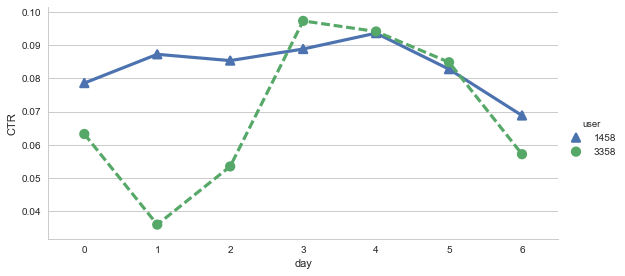

In [84]:
sns.set(style="whitegrid")
ax2 = sns.factorplot(x='day', y='CTR', data=CTR_d1, hue='user',
              markers=["^", "o"], linestyles=["-", "--"], size=4, aspect=2)
#fig = ax2.get_figure()
ax2.savefig('day-ctr.eps', format='eps', dpi=15)

In [92]:
# 2. Analyzing CTR per hour


CTR2 = pd.DataFrame()
CTR2['hour'] = np.sort(train.hour.unique())

hour = train.groupby('hour')
hour_advertiser= train.groupby(['advertiser','hour'])


click_count3 = hour_advertiser.click.value_counts()

totalclicks_1458 = click_count3.iloc[click_count3.index.get_level_values('advertiser') == 1458]
CTR2['totalclicks_1458'] = totalclicks_1458.iloc[totalclicks_1458.index.get_level_values('click') == 1].values

totalclicks_3358 = click_count3.iloc[click_count3.index.get_level_values('advertiser') == 3358]
clicks_3358 = list(totalclicks_3358.iloc[totalclicks_3358.index.get_level_values('click') == 1].values)
clicks_3358 = clicks_3358[:4] + [0] + clicks_3358[4:]
CTR2['totalclicks_3358']= clicks_3358

impressions_hour = hour.advertiser.value_counts()
CTR2['total_impressions_1458'] = impressions_hour.iloc[impressions_hour.index.get_level_values('advertiser') == 1458].values

CTR2['total_impressions_3358'] = impressions_hour.iloc[impressions_hour.index.get_level_values('advertiser') == 3358].values

CTR2['CTR_1458'] = ((CTR2.totalclicks_1458 / CTR2.total_impressions_1458) * 100).round(4)
CTR2['CTR_3358'] = ((CTR2.totalclicks_3358 / CTR2.total_impressions_3358) * 100).round(4)
CTR2


,hour,totalclicks_1458,totalclicks_3358,total_impressions_1458,total_impressions_3358,CTR_1458,CTR_3358
0,0,23,70,25499,72359,0.0902,0.0967
1,1,8,8,11251,7583,0.0711,0.1055
2,2,14,2,6811,3527,0.2055,0.0567
3,3,6,2,7189,1447,0.0835,0.1382
4,4,6,0,3580,1307,0.1676,0.0000
5,5,4,1,4292,1103,0.0932,0.0907
6,6,2,4,5138,2797,0.0389,0.1430
7,7,5,1,10675,2835,0.0468,0.0353
8,8,9,6,15682,7960,0.0574,0.0754
9,9,18,1,19621,4700,0.0917,0.0213


//anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
//anaconda/envs/tensorflow/lib/python3.5/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
//anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

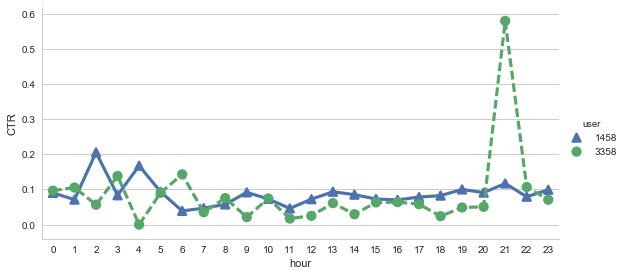

In [86]:
CTR_h1 = CTR2[['hour','CTR_1458']]
CTR_h1['user'] = 1458
CTR_h1.rename(index=str, columns={'CTR_1458':'CTR'}, inplace=True)
CTR_h2 = CTR2[['hour','CTR_3358']]
CTR_h2['user'] = 3358
CTR_h2.rename(index=str, columns={'CTR_3358':'CTR'}, inplace=True)

CTR_h1 = CTR_h1.append(CTR_h2)

sns.set(style="whitegrid")
ax3=sns.factorplot(x='hour', y='CTR', data=CTR_h1, hue='user',
              markers=["^", "o"], linestyles=["-", "--"], size=4, aspect=2)

ax3.savefig('hour-ctr.eps', format='eps', dpi=15)



In [87]:
CTR3 = pd.DataFrame()
CTR3['region'] = np.sort(train.region.unique())

region = train.groupby('region')
region_advertiser= train.groupby(['advertiser','region'])

impressions = region.advertiser.value_counts()
click_countR = region_advertiser.click.value_counts()

totalclicks_1458 = click_countR.iloc[click_countR.index.get_level_values('advertiser') == 1458]
totalclicks_1458.iloc[totalclicks_1458.index.get_level_values('click') == 0]=0
CTR3['totalclicks_1458'] = totalclicks_1458.groupby(level='region').sum().values

totalclicks_3358 = click_countR.iloc[click_countR.index.get_level_values('advertiser') == 3358]
totalclicks_3358.iloc[totalclicks_3358.index.get_level_values('click') == 0]=0
CTR3['totalclicks_3358'] = totalclicks_3358.groupby(level='region').sum().values
# CTR3['totalclicks_3358'] = totalclicks_3358.iloc[totalclicks_3358.index.get_level_values('click') == 1].values

CTR3['total_impressions_1458'] = impressions.iloc[impressions.index.get_level_values('advertiser') == 1458].values

CTR3['total_impressions_3358'] = impressions.iloc[impressions.index.get_level_values('advertiser') == 3358].values

CTR3['CTR_1458'] = ((CTR3.totalclicks_1458 / CTR3.total_impressions_1458) * 100).round(4)
CTR3['CTR_3358'] = ((CTR3.totalclicks_3358 / CTR3.total_impressions_3358) * 100).round(4)

//anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
//anaconda/envs/tensorflow/lib/python3.5/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
//anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

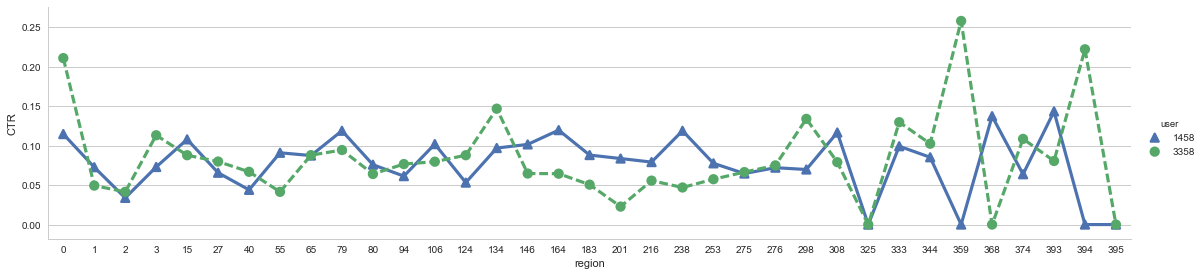

In [89]:
CTR_h1 = CTR3[['region','CTR_1458']]
CTR_h1['user'] = 1458
CTR_h1.rename(index=str, columns={'CTR_1458':'CTR'}, inplace=True)
CTR_h2 = CTR3[['region','CTR_3358']]
CTR_h2['user'] = 3358
CTR_h2.rename(index=str, columns={'CTR_3358':'CTR'}, inplace=True)

CTR_h1 = CTR_h1.append(CTR_h2)

sns.set(style="whitegrid")
ax4=sns.factorplot(x='region', y='CTR', data=CTR_h1, hue='user',
              markers=["^", "o"], linestyles=["-", "--"], size=4, aspect=4)
ax4.savefig('region-ctr.eps', format='eps', dpi=15)


In [90]:
CTR4 = pd.DataFrame()
CTR4['adexchange'] = np.sort(train.adexchange.unique())
CTR4= CTR4.drop([3,4])

adexchange = train.groupby('adexchange')
adexchange_advertiser= train.groupby(['advertiser','adexchange'])

impressions_adexchange = adexchange.advertiser.value_counts()
click_countA = adexchange_advertiser.click.value_counts()

totalclicks_1458 = click_countA.iloc[click_countA.index.get_level_values('advertiser') == 1458]
totalclicks_1458.iloc[totalclicks_1458.index.get_level_values('click') == 0]=0
CTR4['totalclicks_1458'] = totalclicks_1458.groupby(level='adexchange').sum().values

totalclicks_3358 = click_countA.iloc[click_countA.index.get_level_values('advertiser') == 3358]
totalclicks_3358.iloc[totalclicks_3358.index.get_level_values('click') == 0]=0
CTR4['totalclicks_3358'] = totalclicks_3358.groupby(level='adexchange').sum().values
# CTR3['totalclicks_3358'] = totalclicks_3358.iloc[totalclicks_3358.index.get_level_values('click') == 1].values

CTR4['total_impressions_1458'] = impressions_adexchange.iloc[impressions_adexchange.index.get_level_values('advertiser') == 1458].values

CTR4['total_impressions_3358'] = impressions_adexchange.iloc[impressions_adexchange.index.get_level_values('advertiser') == 3358].values

CTR4['CTR_1458'] = ((CTR4.totalclicks_1458 / CTR4.total_impressions_1458) * 100).round(4)
CTR4['CTR_3358'] = ((CTR4.totalclicks_3358 / CTR4.total_impressions_3358) * 100).round(4)

//anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
//anaconda/envs/tensorflow/lib/python3.5/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
//anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

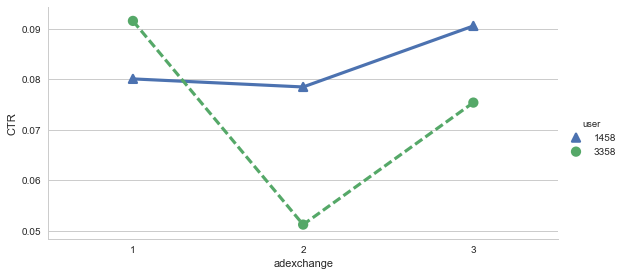

In [91]:
CTR_h1 = CTR4[['adexchange','CTR_1458']]
CTR_h1['user'] = 1458
CTR_h1.rename(index=str, columns={'CTR_1458':'CTR'}, inplace=True)
CTR_h2 = CTR4[['adexchange','CTR_3358']]
CTR_h2['user'] = 3358
CTR_h2.rename(index=str, columns={'CTR_3358':'CTR'}, inplace=True)

CTR_h1 = CTR_h1.append(CTR_h2)

sns.set(style="whitegrid")
ax5=sns.factorplot(x='adexchange', y='CTR', data=CTR_h1, hue='user',
              markers=["^", "o"], linestyles=["-", "--"], size=4, aspect=2)
ax5.savefig('adexchange-ctr.eps', format='eps', dpi=15)


# EPEC

In [11]:
EPEC = pd.DataFrame()
EPEC['day'] = np.sort(train.weekday.unique())

#click = train.groupby('weekday').click.value_counts()

click = train.groupby(['advertiser','weekday']).click.value_counts()
clickall_3358 = click.iloc[click.index.get_level_values('advertiser') == 3358]
EPEC['clicks_3358'] = clickall_3358.iloc[clickall_3358.index.get_level_values('click') == 1].values


#payprice_1458 = train.groupby(['weekday','advertiser']).payprice.sum()
#EPEC['payprice_1458'] = payprice_1458.iloc[payprice_1458.index.get_level_values('advertiser') == 1458].values

payprice_3358 = train.groupby(['weekday','advertiser']).payprice.sum()
EPEC['payprice_3358'] = payprice_3358.iloc[payprice_3358.index.get_level_values('advertiser') == 3358].values

#EPEC['ECPC_1458'] = ((EPEC.payprice_1458 / EPEC.imps_1458) * 100).round(3)
EPEC['ECPC_3358_weekday'] = ((EPEC.payprice_3358 / EPEC.clicks_3358) * 100).round(3)

In [18]:
EPEC


,day,ECPC_3358_weekday
0,0,1.415662e+07
1,1,2.590602e+07
2,2,1.822711e+07
3,3,8.882794e+06
4,4,1.036290e+07
5,5,1.143627e+07
6,6,1.575719e+07


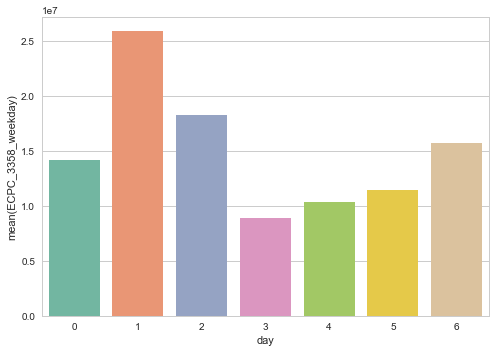

In [49]:
# Boxplot of eCPC for advertiser 3358 for weekdays
a1=EPEC[['day','ECPC_3358_weekday']]

a1 = sns.barplot(a1.day, a1.ECPC_3358_weekday, palette="Set2")
fig = a1.get_figure()
fig.savefig('day-EXPX-3358.eps', format='eps', dpi=15)

In [27]:
hour = pd.DataFrame()

hour['hour'] = np.sort(train.hour.unique())

payprice_hour= train.groupby(['hour','advertiser']).payprice.sum()
hour['payprice_hour'] = payprice_hour.iloc[payprice_hour.index.get_level_values('advertiser') == 3358].values

click = train.groupby(['advertiser','hour']).click.sum()
hour['clicks_3358']= click.iloc[click.index.get_level_values('advertiser') == 3358].values

hour['ECPC_3358_hour'] = ((hour.payprice_hour / hour.clicks_3358) * 100).round(3)

hour

,hour,payprice_hour,clicks_3358,ECPC_3358_hour
0,0,8083997,70,1.154857e+07
1,1,608769,8,7.609612e+06
2,2,264457,2,1.322285e+07
3,3,101112,2,5.055600e+06
4,4,103324,1,1.033240e+07
5,5,75685,0,inf
6,6,287324,4,7.183100e+06
7,7,218351,1,2.183510e+07
8,8,653044,6,1.088407e+07
9,9,368615,1,3.686150e+07


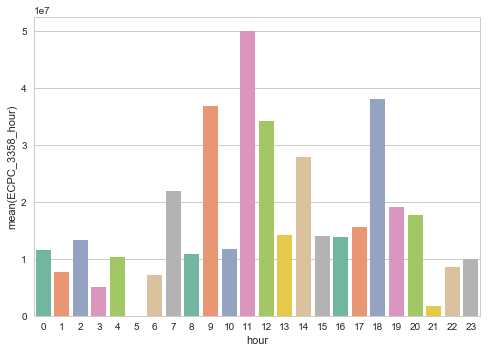

In [47]:
a2=hour[['hour','ECPC_3358_hour']]
a2 = sns.barplot(a2.hour, a2.ECPC_3358_hour, palette="Set2")
fig = a2.get_figure()
fig.savefig('HOUR-EXPX-3358.eps', format='eps', dpi=15)

In [78]:
Region = pd.DataFrame()

Region['Region'] = np.sort(train.region.unique())

payprice_Region= train.groupby(['region','advertiser']).payprice.sum()
Region['payprice_Region'] = payprice_Region.iloc[payprice_Region.index.get_level_values('advertiser') == 3358].values

click = train.groupby(['advertiser','region']).click.sum()
Region['clicks_3358']= click.iloc[click.index.get_level_values('advertiser') == 3358].values

Region['ECPC_3358_region'] = ((Region.payprice_Region / Region.clicks_3358) * 100).round(3)

Region

,Region,payprice_Region,clicks_3358,ECPC_3358_region
0,0,510319,13,3.925531e+06
1,1,1156439,6,1.927398e+07
2,2,466487,2,2.332435e+07
3,3,1271248,15,8.474987e+06
4,15,756615,7,1.080879e+07
5,27,362058,3,1.206860e+07
6,40,853392,6,1.422320e+07
7,55,447169,2,2.235845e+07
8,65,533955,5,1.067910e+07
9,79,975156,9,1.083507e+07


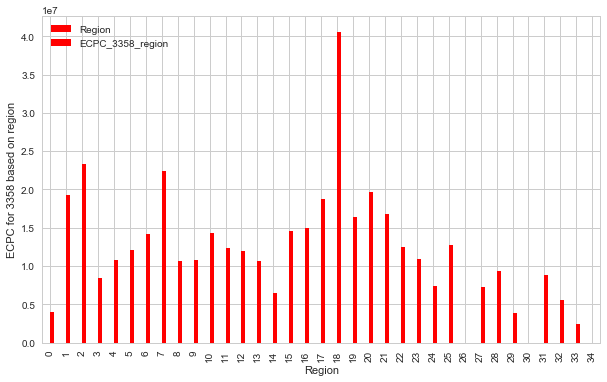

In [69]:
a2=Region[['Region','ECPC_3358_region']]
a2.plot(by='Region',kind='bar',figsize=(10,6), color= 'r')
plt.xlabel("Region")
plt.ylabel("ECPC for 3358 based on region")
plt.savefig('region-EcPc-3358.eps', format='eps', dpi=50)
plt.show()

In [63]:
adexchange = pd.DataFrame()

adexchange['adexchange'] = np.sort(train.adexchange.unique())
adexchange = adexchange.drop([3,4])

payprice_adexchange= train.groupby(['adexchange','advertiser']).payprice.sum()
adexchange['payprice_Adexchange'] = payprice_adexchange.iloc[payprice_adexchange.index.get_level_values('advertiser') == 3358].values

click = train.groupby(['advertiser','adexchange']).click.sum()
adexchange['clicks_3358']= click.iloc[click.index.get_level_values('advertiser') == 3358].values

adexchange['ECPC_3358_adexchange'] = ((adexchange.payprice_Adexchange / adexchange.clicks_3358) * 100).round(3)

adexchange

,adexchange,payprice_Adexchange,clicks_3358,ECPC_3358_adexchange
0,1,17227438,146,1.179962e+07
1,2,7293307,48,1.519439e+07
2,3,3624543,39,9.293700e+06


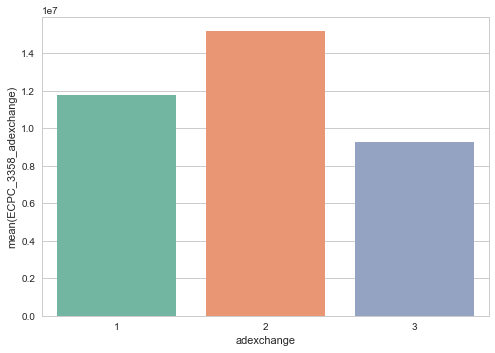

In [64]:
a6=adexchange[['adexchange','ECPC_3358_adexchange']]
a6 = sns.barplot(a6.adexchange, a6.ECPC_3358_adexchange, palette="Set2")
fig = a6.get_figure()
fig.savefig('adexchange-EXPX-3358.eps', format='eps', dpi=15)

# Payprice Comparison for advertiser 1458 and 3358

In [65]:
market = pd.DataFrame()
market['day'] = np.sort(train.weekday.unique())

#click = train.groupby('weekday').click.value_counts()

# click = train.groupby(['advertiser','weekday']).click.value_counts()
# clickall_3358 = click.iloc[click.index.get_level_values('advertiser') == 3358]
# EPEC['clicks_3358'] = clickall_3358.iloc[clickall_3358.index.get_level_values('click') == 1].values


payprice_1458 = train.groupby(['weekday','advertiser']).payprice.sum()
market['payprice_1458'] = payprice_1458.iloc[payprice_1458.index.get_level_values('advertiser') == 1458].values

payprice_3358 = train.groupby(['weekday','advertiser']).payprice.sum()
market['payprice_3358'] = payprice_3358.iloc[payprice_3358.index.get_level_values('advertiser') == 3358].values

market

,day,payprice_1458,payprice_3358
0,0,5322050,2972890
1,1,5319589,2849662
2,2,5308756,2551796
3,3,5345263,7017407
4,4,5332829,4041530
5,5,5308751,5718136
6,6,5294001,2993867


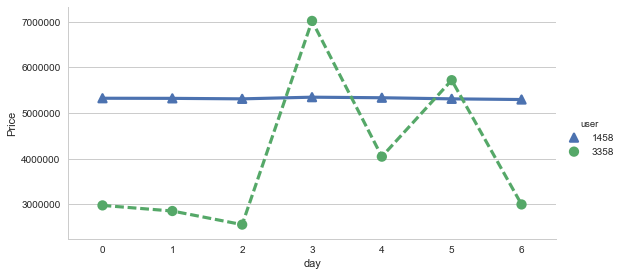

In [105]:
CTR_h1 = market[['day','payprice_1458']]
CTR_h1['user'] = 1458
CTR_h1.rename(index=str, columns={'payprice_1458':'Price'}, inplace=True)
CTR_h2 = market[['day','payprice_3358']]
CTR_h2['user'] = 3358
CTR_h2.rename(index=str, columns={'payprice_3358':'Price'}, inplace=True)

CTR_h1 = CTR_h1.append(CTR_h2)

sns.set(style="whitegrid")
ax4=sns.factorplot(x='day', y='Price', data=CTR_h1, hue='user',
              markers=["^", "o"], linestyles=["-", "--"], size=4, aspect=2)
ax4.savefig('Weekdays-market.eps', format='eps', dpi=15)

In [72]:
market1 = pd.DataFrame()
market1['hour'] = np.sort(train.hour.unique())

payprice = train.groupby(['hour','advertiser']).payprice.sum()
market1['payprice_1458_hour'] = payprice.iloc[payprice.index.get_level_values('advertiser') == 1458].values

market1['payprice_3358_hour'] = payprice.iloc[payprice.index.get_level_values('advertiser') == 3358].values

market1

,hour,payprice_1458_hour,payprice_3358_hour
0,0,1681052,8083997
1,1,705333,608769
2,2,441005,264457
3,3,500885,101112
4,4,241169,103324
5,5,303420,75685
6,6,334901,287324
7,7,739356,218351
8,8,1123491,653044
9,9,1338139,368615


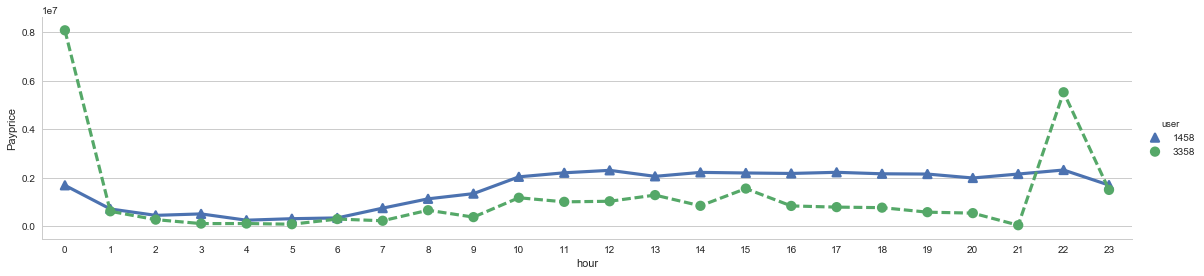

In [106]:
CTR_h1 = market1[['hour','payprice_1458_hour']]
CTR_h1['user'] = 1458
CTR_h1.rename(index=str, columns={'payprice_1458_hour':'Payprice'}, inplace=True)
CTR_h2 = market1[['hour','payprice_3358_hour']]
CTR_h2['user'] = 3358
CTR_h2.rename(index=str, columns={'payprice_3358_hour':'Payprice'}, inplace=True)

CTR_h1 = CTR_h1.append(CTR_h2)

sns.set(style="whitegrid")
ax4=sns.factorplot(x='hour', y='Payprice', data=CTR_h1, hue='user',
              markers=["^", "o"], linestyles=["-", "--"], size=4, aspect=4)
ax4.savefig('hour-market.eps', format='eps', dpi=15)

In [96]:
market1[['hour','payprice_3358_hour']]

,hour,payprice_3358_hour
0,0,8083997
1,1,608769
2,2,264457
3,3,101112
4,4,103324
5,5,75685
6,6,287324
7,7,218351
8,8,653044
9,9,368615
